In [1]:
import os
from os.path import join

import sys
import numpy as np
import glob
from itertools import islice

import pathlib
from pathlib import Path

from PIL import Image

from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip "drive/MyDrive/Colab Notebooks/celeba.zip"

Archive:  drive/MyDrive/Colab Notebooks/celeba.zip
   creating: celeba/
  inflating: celeba/img_align_celeba.zip  
  inflating: __MACOSX/celeba/._img_align_celeba.zip  
  inflating: celeba/list_attr_celeba.txt  
  inflating: __MACOSX/celeba/._list_attr_celeba.txt  
  inflating: celeba/.DS_Store        
  inflating: __MACOSX/celeba/._.DS_Store  
  inflating: celeba/list_bbox_celeba.txt  
  inflating: __MACOSX/celeba/._list_bbox_celeba.txt  
  inflating: celeba/list_landmarks_align_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_align_celeba.txt  
  inflating: celeba/list_landmarks_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_celeba.txt  
  inflating: celeba/list_eval_partition.txt  
  inflating: __MACOSX/celeba/._list_eval_partition.txt  
  inflating: celeba/identity_CelebA.txt  
  inflating: __MACOSX/celeba/._identity_CelebA.txt  


In [4]:
!unzip "celeba/img_align_celeba.zip" -d celeba/

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: celeba/img_align_celeba/197600.jpg  
 extracting: celeba/img_align_celeba/197601.jpg  
 extracting: celeba/img_align_celeba/197602.jpg  
 extracting: celeba/img_align_celeba/197603.jpg  
 extracting: celeba/img_align_celeba/197604.jpg  
 extracting: celeba/img_align_celeba/197605.jpg  
 extracting: celeba/img_align_celeba/197606.jpg  
 extracting: celeba/img_align_celeba/197607.jpg  
 extracting: celeba/img_align_celeba/197608.jpg  
 extracting: celeba/img_align_celeba/197609.jpg  
 extracting: celeba/img_align_celeba/197610.jpg  
 extracting: celeba/img_align_celeba/197611.jpg  
 extracting: celeba/img_align_celeba/197612.jpg  
 extracting: celeba/img_align_celeba/197613.jpg  
 extracting: celeba/img_align_celeba/197614.jpg  
 extracting: celeba/img_align_celeba/197615.jpg  
 extracting: celeba/img_align_celeba/197616.jpg  
 extracting: celeba/img_align_celeba/197617.jpg  
 extracting: celeba/img_align_celeba/197618.jpg  
 extracting: celeb

In [5]:
celeba_dataset = torchvision.datasets.CelebA('./', split='train', target_type='attr', download=False)

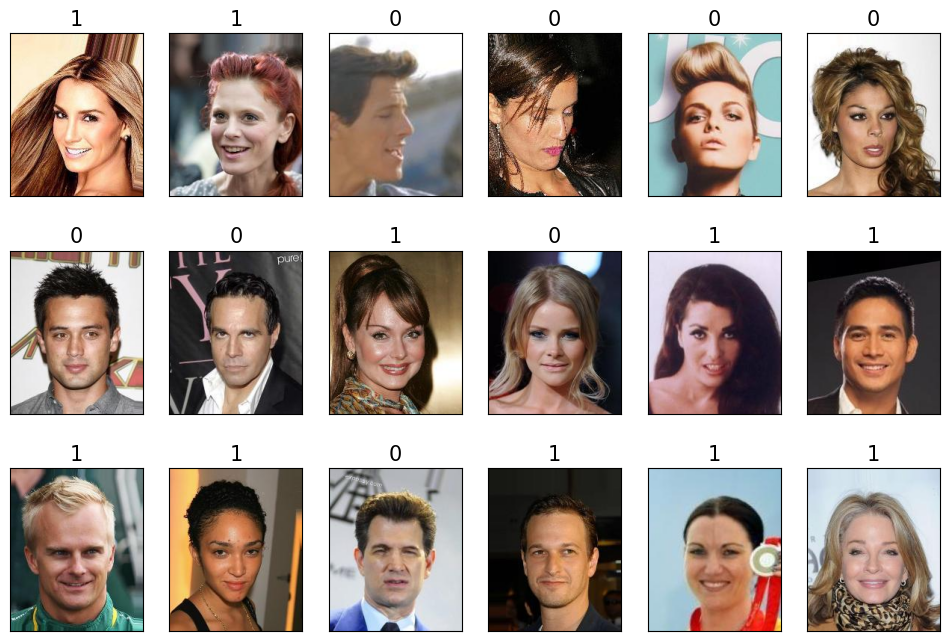

In [6]:

fig = plt.figure(figsize=(12, 8))
for i, (image, attributes) in islice(enumerate(celeba_dataset), 18):
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    ax.set_title(f'{attributes[31]}', size=15)

plt.show()

In [7]:
celeba_train_dataset = torchvision.datasets.CelebA('./', split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA('./', split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA('./', split='test', target_type='attr', download=False)

In [8]:
len(celeba_train_dataset), len(celeba_valid_dataset), len(celeba_test_dataset)

(162770, 19867, 19962)

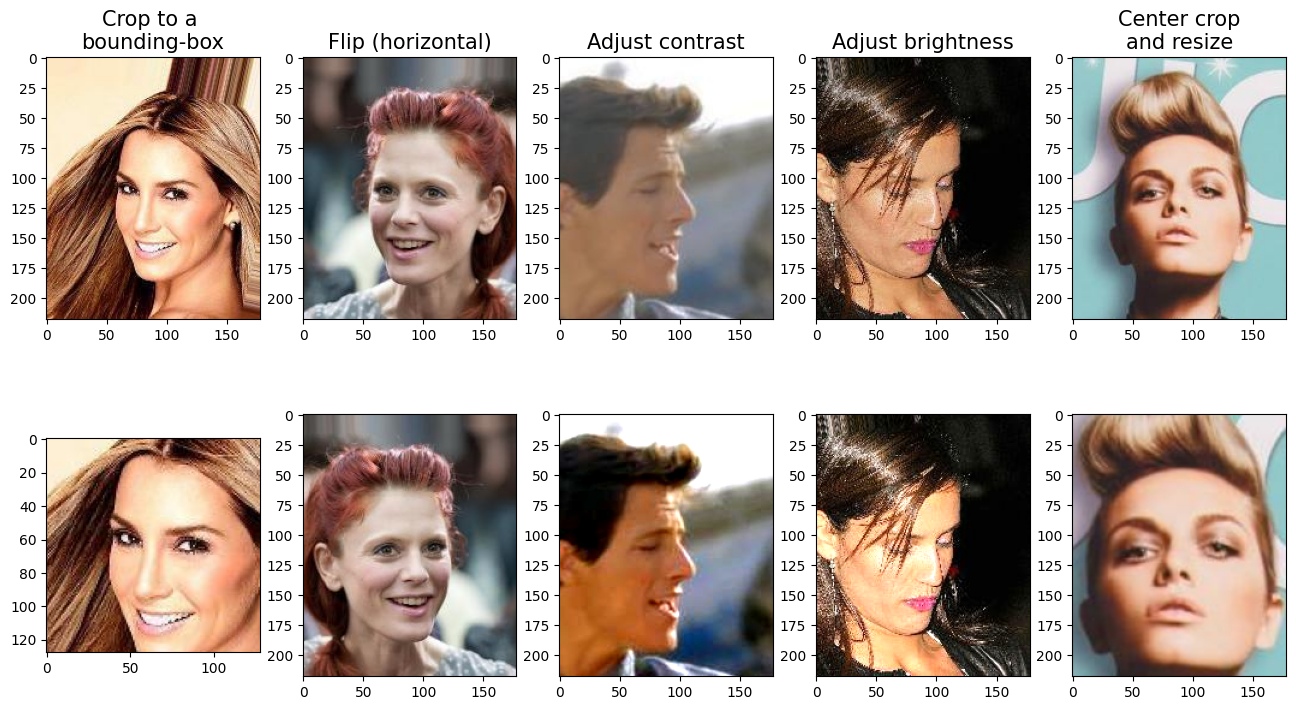

In [9]:
fig = plt.figure(figsize=(16, 8.5))

ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust contrast', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7 * 218, 0.7 * 178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)

plt.show()

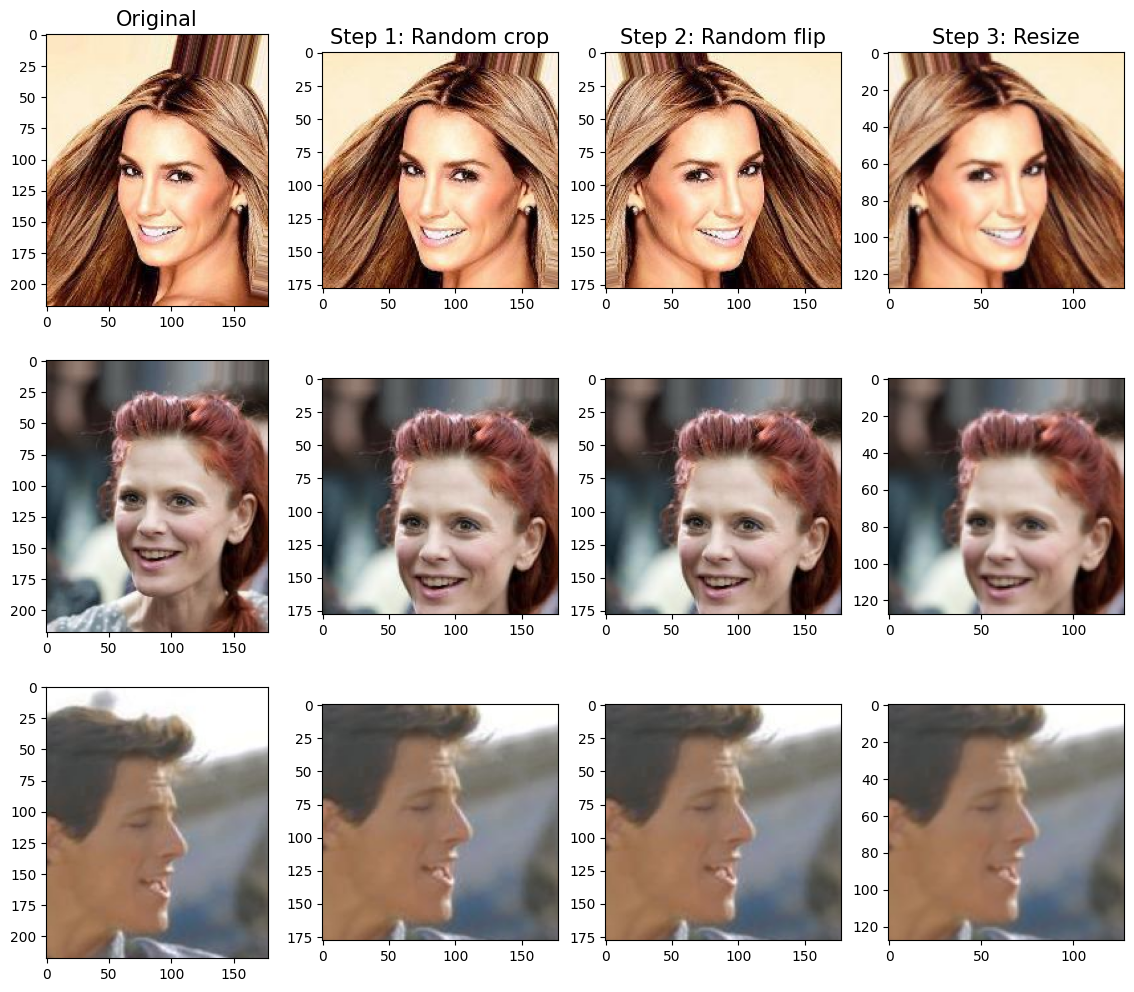

In [10]:
torch.manual_seed(1)
fig = plt.figure(figsize=(14, 12))
for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i * 4 + 1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Original', size=15)

    ax = fig.add_subplot(3, 4, i * 4 + 2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i * 4 + 3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i * 4 + 4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

    if i == 2:
        break

plt.show()

In [11]:
get_smile = lambda attr: attr[31]
transform_train = transforms.Compose([transforms.RandomCrop([178, 178]), transforms.RandomHorizontalFlip(), transforms.Resize([64, 64]), transforms.ToTensor()])
transform = transforms.Compose([transforms.CenterCrop([178, 178]), transforms.Resize([64, 64]), transforms.ToTensor()])

In [12]:
celeba_train_dataset = torchvision.datasets.CelebA('./', split='train', target_type='attr', download=False, transform=transform_train, target_transform=get_smile)
torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

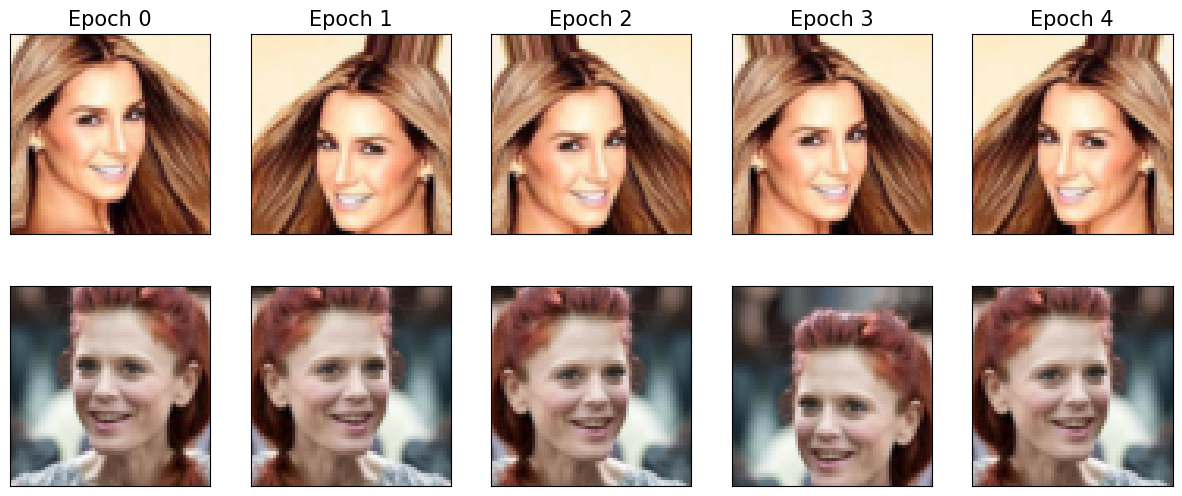

In [13]:
fig = plt.figure(figsize=(15, 6))
for j in range(5):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [14]:
celeba_valid_dataset = torchvision.datasets.CelebA('./', split='valid', target_type='attr', download=False, transform=transform, target_transform=get_smile)
celeba_test_dataset = torchvision.datasets.CelebA('./', split='test', target_type='attr', download=False, transform=transform, target_transform=get_smile)

celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

len(celeba_train_dataset), len(celeba_valid_dataset)

(16000, 1000)

In [15]:
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

In [16]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [17]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [18]:
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [19]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [20]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch + 1} accuracy: {accuracy_hist_train[epoch]} val_accuracy: {accuracy_hist_valid[epoch]}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [22]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5169374942779541 val_accuracy: 0.5139999985694885
Epoch 2 accuracy: 0.5239999890327454 val_accuracy: 0.5519999861717224
Epoch 3 accuracy: 0.5468124747276306 val_accuracy: 0.5130000114440918
Epoch 4 accuracy: 0.577750027179718 val_accuracy: 0.6000000238418579
Epoch 5 accuracy: 0.6166874766349792 val_accuracy: 0.6449999809265137
Epoch 6 accuracy: 0.6370624899864197 val_accuracy: 0.6570000052452087
Epoch 7 accuracy: 0.653249979019165 val_accuracy: 0.6489999890327454
Epoch 8 accuracy: 0.6561874747276306 val_accuracy: 0.6629999876022339
Epoch 9 accuracy: 0.6688125133514404 val_accuracy: 0.6779999732971191
Epoch 10 accuracy: 0.679812490940094 val_accuracy: 0.6759999990463257
Epoch 11 accuracy: 0.695062518119812 val_accuracy: 0.6949999928474426
Epoch 12 accuracy: 0.7047500014305115 val_accuracy: 0.7329999804496765
Epoch 13 accuracy: 0.723437488079071 val_accuracy: 0.6830000281333923
Epoch 14 accuracy: 0.7383124828338623 val_accuracy: 0.7960000038146973
Epoch 15 accuracy: 0

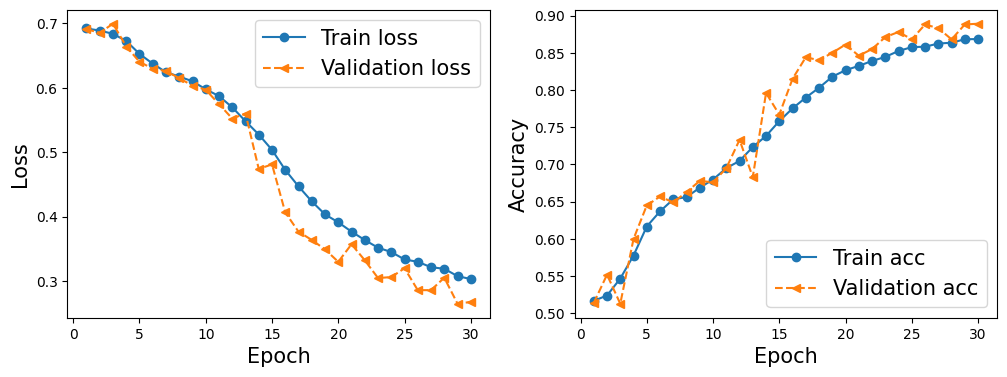

In [23]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc')
ax.plot(x_arr, hist[3], '--<', label='Validation acc')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [25]:
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)
accuracy_test

tensor(0.8972)

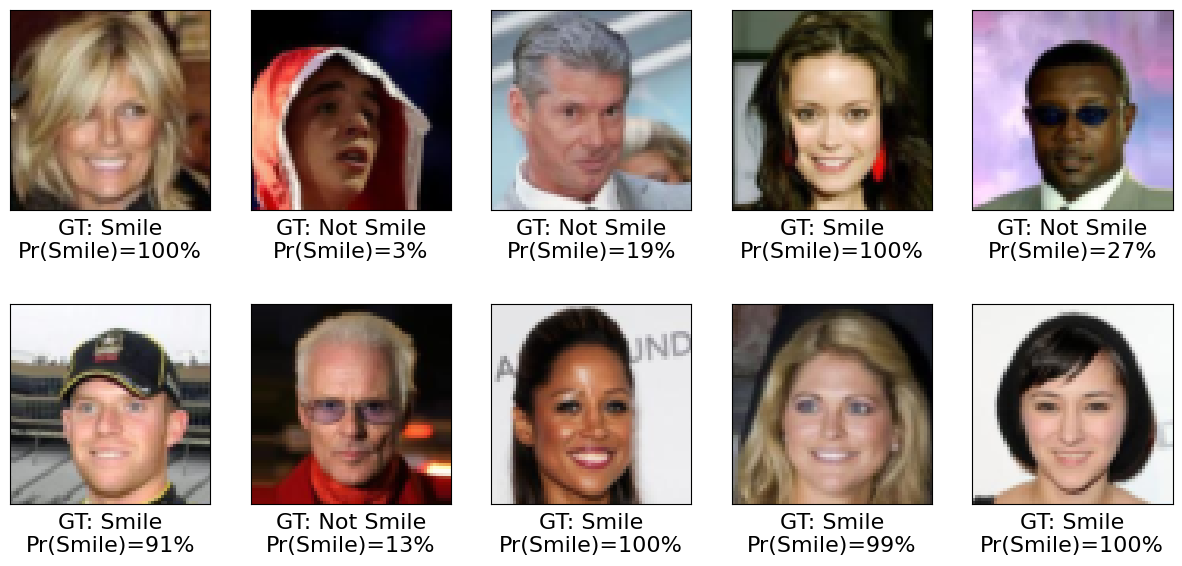

In [26]:
pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j - 9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(0.5, -0.15, f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', size=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()